![image](https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/notebooks/headers/AutoAI-Banner_Pipeline-Notebook.png)
# Pipeline 8 Notebook - AutoAI Notebook v1.16.0

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimum results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>. 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).


<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for getting data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses python 3.9 and scikit-learn 1.0.2.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#setup)**<br>
&nbsp;&nbsp;[Package installation](#install)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#variables_definition)<br>
&nbsp;&nbsp;[Watson Machine Learning connection](#connection)<br>
**[Pipeline inspection](#inspection)** <br>
&nbsp;&nbsp;[Read training data](#read)<br>
&nbsp;&nbsp;[Train and test data split](#split)<br>
&nbsp;&nbsp;[Make pipeline](#preview_model_to_python_code)<br>
&nbsp;&nbsp;[Train pipeline model](#train)<br>
&nbsp;&nbsp;[Test pipeline model](#test_model)<br>
**[Summary and next steps](#summary_and_next_steps)**<br>
**[Copyrights](#copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - scikit-learn,
 - xgboost.


In [1]:
!pip install ibm-watson-machine-learning | tail -n 1
!pip install -U autoai-libs==1.13.2 | tail -n 1
!pip install -U scikit-learn==1.0.2 | tail -n 1
!pip install -U xgboost==1.5.1 | tail -n 1
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 37.8 MB 29.2 MB/s eta 0:00:01████████| 37.8 MB 29.2 MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=cdefa3625115f5071d89d2506bb6cfd6eec3fc7e980e69c8034e7de33f2ef788
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/f2/5e/63/62e00a642415e064a55f53b5095ceb1420d24685125420d3ac
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp39-cp39-linux_x86_64.whl size=8459774 sha256=98f24ea1e904e65ea450051a2b0abf1d0d184bef6f7e94a3bd95a31655d18984
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/25/d0/ab/05f776f079a53f4c6a12c98220910f4d0d245609b8c673a5ad
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=829f9099da1664d180d1c68d58a20b4c2404ee0c20985eac147d6bc172cf8dc6
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Succes

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [71]:
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='2b97fa65-6589-46f7-8a32-1b4d9cbeee9d'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/7f9f2b5a-c0ae-4123-a8bd-168b620907ac/wml_data/488b255b-57ec-4abe-9d5e-188e1dd7f581/data/automl',
        model_location='auto_ml/7f9f2b5a-c0ae-4123-a8bd-168b620907ac/wml_data/488b255b-57ec-4abe-9d5e-188e1dd7f581/data/automl/model.zip',
        training_status='auto_ml/7f9f2b5a-c0ae-4123-a8bd-168b620907ac/wml_data/488b255b-57ec-4abe-9d5e-188e1dd7f581/training-status.json'
    )
)

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [72]:
experiment_metadata = dict(
    prediction_type='binary',
    prediction_column='Survived',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=2,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    deployment_url='https://eu-gb.ml.cloud.ibm.com',
    project_id='e69bc396-b6e7-4eb0-956b-c09236f1b185',
    positive_label=1,
    drop_duplicates=True
)

## Set `n_jobs` parameter to the number of available CPUs

In [73]:
import os, ast
CPU_NUMBER = 2
if 'RUNTIME_HARDWARE_SPEC' in os.environ:
    CPU_NUMBER = int(ast.literal_eval(os.environ['RUNTIME_HARDWARE_SPEC'])['num_cpu'])

<a id="connection"></a>
## Watson Machine Learning connection

This cell defines the credentials required to work with the Watson Machine Learning service.

**Action:** Please provide IBM Cloud apikey following [docs](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [74]:
api_key = 'NdyX99jFXsfJMXM2pQeN7V-Ja_4lJtGSyW6MRIQpz9Rx'

In [75]:
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

In [76]:
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(wml_credentials)

if 'space_id' in experiment_metadata:
    wml_client.set.default_space(experiment_metadata['space_id'])
else:
    wml_client.set.default_project(experiment_metadata['project_id'])
    
training_data_references[0]._wml_client = wml_client



<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

**Note**: If reading data results in an error, provide data as Pandas DataFrame object, for example, reading .CSV file with `pandas.read_csv()`. It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.

In [77]:
train_X, test_X, train_y, test_y = training_data_references[0].read(experiment_metadata=experiment_metadata, with_holdout_split=True)

In [78]:
train_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
731,732.0,3.0,"Hassan, Mr. Houssein G N",male,11.0,0.0,0.0,2699,18.7875,None,C
152,153.0,3.0,"Meo, Mr. Alfonzo",male,55.5,0.0,0.0,A.5. 11206,8.0500,None,S
566,567.0,3.0,"Stoytcheff, Mr. Ilia",male,19.0,0.0,0.0,349205,7.8958,None,S
808,809.0,2.0,"Meyer, Mr. August",male,39.0,0.0,0.0,248723,13.0000,None,S
443,444.0,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S


<a id="preview_model_to_python_code"></a>
## Make pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

#### Import statements.

In [79]:
from autoai_libs.transformers.text_transformers import TextTransformer
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA1
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from xgboost import XGBClassifier

In [80]:
text_transformer_0 = TextTransformer(
    text_processing_options={"word2vec": {"output_dim": 20}},
    column_headers_list=[
        "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin",
        "Embarked", "NewTextFeature_0_word2vec(Name)",
        "NewTextFeature_1_word2vec(Name)", "NewTextFeature_2_word2vec(Name)",
        "NewTextFeature_3_word2vec(Name)", "NewTextFeature_4_word2vec(Name)",
        "NewTextFeature_5_word2vec(Name)", "NewTextFeature_6_word2vec(Name)",
        "NewTextFeature_7_word2vec(Name)", "NewTextFeature_8_word2vec(Name)",
        "NewTextFeature_9_word2vec(Name)", "NewTextFeature_10_word2vec(Name)",
        "NewTextFeature_11_word2vec(Name)",
        "NewTextFeature_12_word2vec(Name)",
        "NewTextFeature_13_word2vec(Name)",
        "NewTextFeature_14_word2vec(Name)",
        "NewTextFeature_15_word2vec(Name)",
        "NewTextFeature_16_word2vec(Name)",
        "NewTextFeature_17_word2vec(Name)",
        "NewTextFeature_18_word2vec(Name)",
        "NewTextFeature_19_word2vec(Name)",
    ],
    columns_to_be_deleted=[0, 2],
    drop_columns=True,
    text_columns=[2],
)
numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 3, 4, 5, 7, 8])
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "int_num", "char_str", "int_num", "int_num", "char_str", "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[], [], [], [], [], [float("nan")], [float("nan")]],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[float("nan")], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"),
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=float("nan"),
    sklearn_version_family="1",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="1",
)
pipeline_0 = make_pipeline(
    text_transformer_0,
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
text_transformer_1 = TextTransformer(
    text_processing_options={"word2vec": {"output_dim": 20}},
    column_headers_list=[
        "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin",
        "Embarked", "NewTextFeature_0_word2vec(Name)",
        "NewTextFeature_1_word2vec(Name)", "NewTextFeature_2_word2vec(Name)",
        "NewTextFeature_3_word2vec(Name)", "NewTextFeature_4_word2vec(Name)",
        "NewTextFeature_5_word2vec(Name)", "NewTextFeature_6_word2vec(Name)",
        "NewTextFeature_7_word2vec(Name)", "NewTextFeature_8_word2vec(Name)",
        "NewTextFeature_9_word2vec(Name)", "NewTextFeature_10_word2vec(Name)",
        "NewTextFeature_11_word2vec(Name)",
        "NewTextFeature_12_word2vec(Name)",
        "NewTextFeature_13_word2vec(Name)",
        "NewTextFeature_14_word2vec(Name)",
        "NewTextFeature_15_word2vec(Name)",
        "NewTextFeature_16_word2vec(Name)",
        "NewTextFeature_17_word2vec(Name)",
        "NewTextFeature_18_word2vec(Name)",
        "NewTextFeature_19_word2vec(Name)",
    ],
    columns_to_be_deleted=[0, 2],
    drop_columns=True,
    text_columns=[2],
)
numpy_column_selector_1 = NumpyColumnSelector(
    columns=[
        2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28,
    ]
)
float_str2_float = FloatStr2Float(
    dtypes_list=[
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num",
    ],
    missing_values_reference_list=[float("nan")],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[float("nan")], filling_values=float("nan")
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(use_scaler_flag=False)
pipeline_1 = make_pipeline(
    text_transformer_1,
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0, 1, 3, 4, 5, 7, 8, 2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28,
    ],
)
ta1_0 = TA1(
    fun=np.sqrt,
    name="sqrt",
    datatypes=["numeric"],
    feat_constraints=[
        autoai_libs.utils.fc_methods.is_non_negative,
        autoai_libs.utils.fc_methods.is_not_categorical,
    ],
    col_names=[
        "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin",
        "Embarked", "NewTextFeature_0_word2vec(Name)",
        "NewTextFeature_1_word2vec(Name)", "NewTextFeature_2_word2vec(Name)",
        "NewTextFeature_3_word2vec(Name)", "NewTextFeature_4_word2vec(Name)",
        "NewTextFeature_5_word2vec(Name)", "NewTextFeature_6_word2vec(Name)",
        "NewTextFeature_7_word2vec(Name)", "NewTextFeature_8_word2vec(Name)",
        "NewTextFeature_9_word2vec(Name)", "NewTextFeature_10_word2vec(Name)",
        "NewTextFeature_11_word2vec(Name)",
        "NewTextFeature_12_word2vec(Name)",
        "NewTextFeature_13_word2vec(Name)",
        "NewTextFeature_14_word2vec(Name)",
        "NewTextFeature_15_word2vec(Name)",
        "NewTextFeature_16_word2vec(Name)",
        "NewTextFeature_17_word2vec(Name)",
        "NewTextFeature_18_word2vec(Name)",
        "NewTextFeature_19_word2vec(Name)",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 29),
    additional_col_count_to_keep=20,
    ptype="classification",
)
ta1_1 = TA1(
    fun=np.square,
    name="square",
    datatypes=["numeric"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin",
        "Embarked", "NewTextFeature_0_word2vec(Name)",
        "NewTextFeature_1_word2vec(Name)", "NewTextFeature_2_word2vec(Name)",
        "NewTextFeature_3_word2vec(Name)", "NewTextFeature_4_word2vec(Name)",
        "NewTextFeature_5_word2vec(Name)", "NewTextFeature_6_word2vec(Name)",
        "NewTextFeature_7_word2vec(Name)", "NewTextFeature_8_word2vec(Name)",
        "NewTextFeature_9_word2vec(Name)", "NewTextFeature_10_word2vec(Name)",
        "NewTextFeature_11_word2vec(Name)",
        "NewTextFeature_12_word2vec(Name)",
        "NewTextFeature_13_word2vec(Name)",
        "NewTextFeature_14_word2vec(Name)",
        "NewTextFeature_15_word2vec(Name)",
        "NewTextFeature_16_word2vec(Name)",
        "NewTextFeature_17_word2vec(Name)",
        "NewTextFeature_18_word2vec(Name)",
        "NewTextFeature_19_word2vec(Name)", "sqrt(Age)", "sqrt(Fare)",
        "sqrt(Cabin)", "sqrt(NewTextFeature_0_word2vec(Name))",
        "sqrt(NewTextFeature_1_word2vec(Name))",
        "sqrt(NewTextFeature_2_word2vec(Name))",
        "sqrt(NewTextFeature_3_word2vec(Name))",
        "sqrt(NewTextFeature_4_word2vec(Name))",
        "sqrt(NewTextFeature_5_word2vec(Name))",
        "sqrt(NewTextFeature_7_word2vec(Name))",
        "sqrt(NewTextFeature_9_word2vec(Name))",
        "sqrt(NewTextFeature_10_word2vec(Name))",
        "sqrt(NewTextFeature_11_word2vec(Name))",
        "sqrt(NewTextFeature_12_word2vec(Name))",
        "sqrt(NewTextFeature_13_word2vec(Name))",
        "sqrt(NewTextFeature_14_word2vec(Name))",
        "sqrt(NewTextFeature_15_word2vec(Name))",
        "sqrt(NewTextFeature_16_word2vec(Name))",
        "sqrt(NewTextFeature_17_word2vec(Name))",
        "sqrt(NewTextFeature_18_word2vec(Name))",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 29),
    additional_col_count_to_keep=20,
    ptype="classification",
)
xgb_classifier = XGBClassifier(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=1,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=0.020000000025298847,
    max_delta_step=0,
    max_depth=7,
    min_child_weight=2,
    missing=float("nan"),
    monotone_constraints="()",
    n_estimators=130,
    n_jobs=CPU_NUMBER,
    num_parallel_tree=1,
    predictor="auto",
    random_state=33,
    reg_alpha=0,
    reg_lambda=0.29570869300556984,
    scale_pos_weight=1,
    subsample=0.9993208891612426,
    tree_method="hist",
    validate_parameters=1,
    verbosity=0,
    nthread=2,
    silent=True,
    seed=33,
)


#### Pipeline.

In [81]:
pipeline = make_pipeline(
    union, numpy_permute_array, ta1_0, fs1_0, ta1_1, fs1_1, xgb_classifier
)

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [82]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [83]:
# train_X = train_X.dropna(axis=0, subset=['Age', 'Fare'], how='any')
# test_X = test_X.dropna(axis=0, subset=['Age', 'Fare'], how='any')

# train_y = train_y.loc[train_X.index]
# test_y = test_y.loc[test_X.index]

In [84]:
pipeline.fit(train_X.values, train_y.values);

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [85]:
score = scorer(pipeline, test_X.values, test_y.values)
print(score)

0.8333333333333334


In [86]:
pipeline.predict(test_X.values)

array([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1.])

<a id="summary_and_next_steps"></a>
# Summary and next steps
You successfully completed this notebook!
You learned how to use AutoAI pipeline definition to train the model.
Check out our [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai) for more samples, tutorials, documentation, how-tos, and blog posts.

# Our pipeline

In [102]:
print(f'Number of observations in the train set: {len(train_X)}')
print(f'Number of observations in the test set: {len(test_X)}')

Number of observations in the train set: 801
Number of observations in the test set: 90


Now, we need to do some data preprocessing:

1. Fill nan values with string 'None' for 'Cabin' column (will make label encoding easier),
2. Get rid of 'Name' and 'Ticket' columns.

In [188]:
y_train = train_y['Survived'].copy()
X_train = train_X.copy()

y_test = test_y['Survived'].copy()
X_test = test_X.copy()

X_train['Cabin'] = X_train['Cabin'].fillna('None')
X_test['Cabin'] = X_test['Cabin'].fillna('None')

X_train = X_train.drop(columns=['Ticket', 'Name'])
X_test = X_test.drop(columns=['Ticket', 'Name'])

print(f'Number of observations in the train set after preprocessing: {len(X_train)}')
print(f'Number of observations in the test set after preprocessing: {len(X_test)}')

Number of observations in the train set after preprocessing: 801
Number of observations in the test set after preprocessing: 90


## EDA

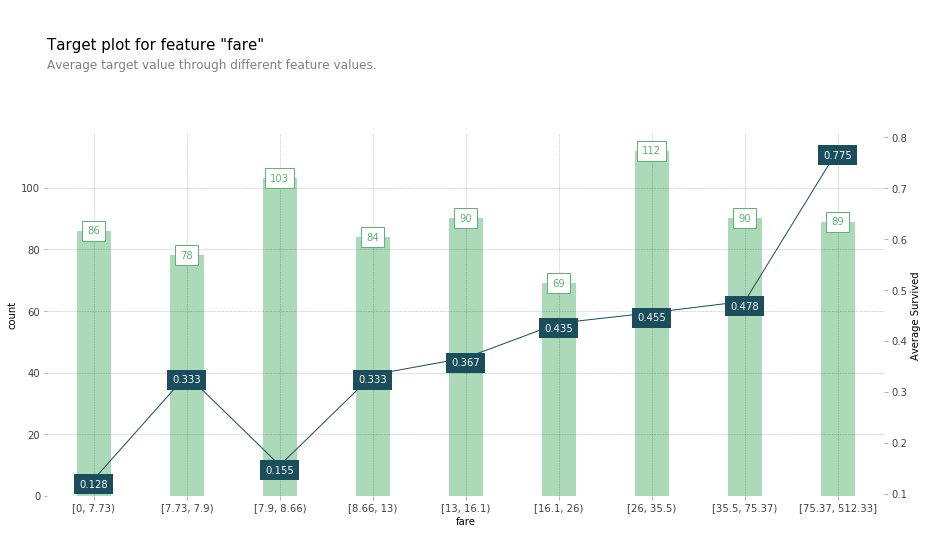

In [193]:
import pandas as pd
from pdpbox import pdp, info_plots
from sklearn.preprocessing import LabelEncoder


X_train_full = pd.concat([X_train, y_train], axis=1)
le = LabelEncoder()

X_train_full['Sex'] = le.fit_transform(X_train_full['Sex'])
X_train_full['Cabin'] = le.fit_transform(X_train_full['Cabin'])

fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Fare', feature_name='fare', target='Survived'
)

Clearly, passengers, who paid lower fares had much lower chances of survival.

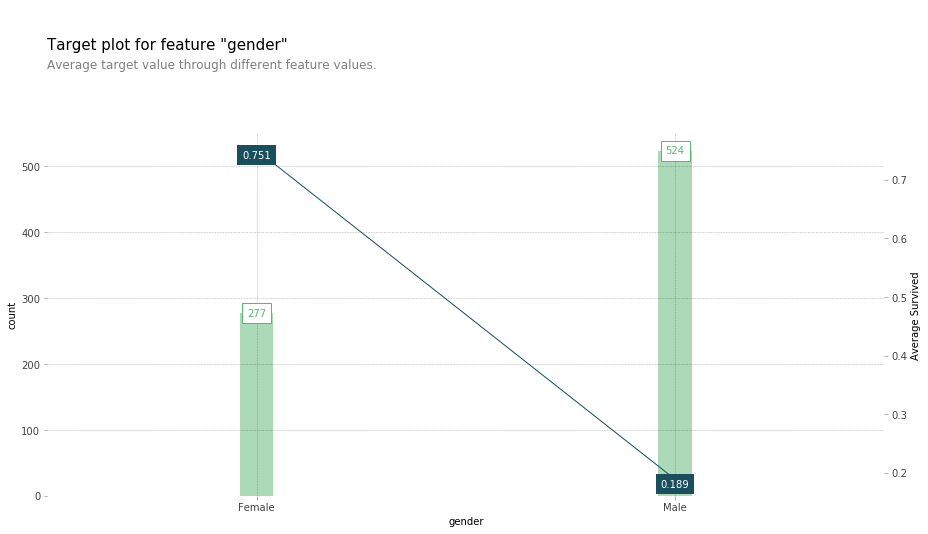

In [194]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_train_full, feature='Sex', feature_name='gender', target='Survived'
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

Women were much more likely to survive than men.

## Data preprocessing

Now, we will prepare a pipeline for our future predictors. We have two numerical features - Age and Fare, which we will standardize. As for other, categorical, variables - we will encode them as binary vectors, so-called one-hot vectors.

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Cabin', 'Sex', 'Pclass', 'SibSp', 'Parch']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Cabin', 'Sex', 'Pclass', 'SibSp', 'Parch'])])


## xgboost

In [111]:
import xgboost as xgb

In [190]:
model = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('classifier',
                          xgb.XGBClassifier(objective='binary:logistic', base_score=0.5, booster="gbtree", 
                                            max_depth=4, random_state=256, n_estimators=100, subsample=0.5, 
                                            subsample_method='gradient_based', learning_rate=0.3, 
                                            n_jobs=CPU_NUMBER, gamma=0.95))])
print(model)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Sex', 'Pclass',
                                                   'SibSp', 'Parch'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=None, colsample_byno...
                               interaction_constraints=None, learning_rate=0.3,
                               ma

Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        55
         1.0       0.82      0.77      0.79        35

    accuracy                           0.84        90
   macro avg       0.84      0.83      0.83        90
weighted avg       0.84      0.84      0.84        90



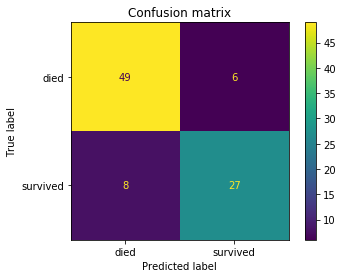

In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import  plot_confusion_matrix, classification_report, accuracy_score


print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

ax = plt.subplot()
ax.set_title('Confusion matrix')
plot_confusion_matrix(model, X_test, y_test, ax=ax)
ax.xaxis.set_ticklabels(['died', 'survived'])
ax.yaxis.set_ticklabels(['died', 'survived'])
plt.show()

# Model comparison

In [192]:
print(f'Accuracy of AutoML model: {score:.4f}')
print(f'Accuracy of our model: {accuracy_score(y_test, y_pred):.4f}')

Accuracy of AutoML model: 0.8333
Accuracy of our model: 0.8444


<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2022 IBM. This notebook and its source code are released under the terms of the ILAN License. Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___